# Aim

To understand the sparse decoding algorithm from scratch, this is a full implementation of the algorithm just off the paper (Ramchandran-papers.nips.cc-2015).

A lot of things should be vectorizable, but the dimensions aren't happy with that so I'll just ignore it. So there may be slight inefficiencies here.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import itertools
%matplotlib inline
np.random.seed(42)

In [2]:
def myfwht(x):
    """Recursive implementation of the 1D Cooley-Tukey FFT"""
    # x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N == 1:
        return x
    else:
        X_even = myfwht(x[0:(N//2)])
        X_odd = myfwht(x[(N//2):])
        return np.concatenate([(X_even + X_odd),
                               (X_even - X_odd)])
    
def bin_to_dec(x):
    n = len(x)
    c = 2**(np.arange(n)[::-1])
    return c.dot(x).astype(np.int)

def dec_to_bin(x, num_bits):
    assert x < 2**num_bits, "number of bits are not enough"
    u = bin(x)[2:].zfill(num_bits)
    u = list(u)
    u = [int(i) for i in u]
    return np.array(u)

In [3]:
def make_input_signal(n, loc, strengths, noise_sd):
    '''
    Arguments
    ---------
    n : int
    number of bits
    
    loc : iterable
    Locations of peaks in the W-H spectrum. Elements must be integers in [0, 2 ** n - 1].
    
    strengths : iterable
    The strength of each peak in the W-H spectrum. Defaults to all 1s. Dimension has to match that of loc.
    
    noise_sd : scalar
    The SD of the added noise.
    
    Returns
    -------
    input_signal : numpy.ndarray
    The time signal.
    
    input_wht : numpy.ndarray
    The WHT of input_signal.
    '''
    N = 2 ** n
    if strengths is None:
        strengths = np.ones_like(loc)
    input_wht = np.zeros((N,))
    for l, s in zip(loc, strengths):
        input_wht[l] = s
    input_signal = myfwht(input_wht) + np.random.normal(0, noise_sd, (N,))
    return input_signal, myfwht(input_signal) / N

class InputSignal:
    def __init__(self, n, loc, strengths=None, noise_sd=0):
        self.n = n
        self.noise_sd = noise_sd
        self.signal_t, self.signal_w = make_input_signal(n, loc, strengths, noise_sd)


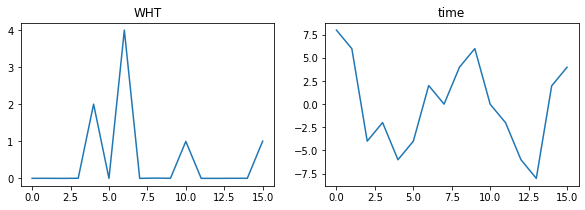

In [4]:
# make signal and plot it
input_signal = InputSignal(4, [4, 6, 10, 15], strengths=[2, 4, 1, 1], noise_sd=0.01)
noiseless_signal = InputSignal(4, [4, 6, 10, 15], strengths=[2, 4, 1, 1], noise_sd=0)
fig, axs = plt.subplots(1,2, figsize=(10,3))

axs[0].plot(input_signal.signal_w)
axs[0].set_title('WHT')

axs[1].plot(input_signal.signal_t)
axs[1].set_title('time')
plt.show()

In [5]:
def subsample_indices(b, M, d):
    '''
    Query generator: creates indices for signal subsamples.
    
    Arguments
    ---------
    b : int
    The subsampling coefficient; subject to b <= n = log2(N).
    
    M : numpy.ndarray, shape (n, b)
    The subsampling matrix; takes on binary values.
    
    d : numpy.ndarray, shape (n,)
    The subsampling offset; takes on binary values.
    
    Returns
    -------
    indices : numpy.ndarray, shape (B,)
    The (decimal) subsample indices. Mostly for debugging purposes.
    
    subsamples : numpy.ndarray, shape (B,)
    The subsampled time signal.
    '''
    B = 2 ** b
    L = np.array(list(map(list, itertools.product([0, 1], repeat=b)))).T
    indices = bin_to_dec(np.mod(np.dot(M, L).T + d, 2).T)
    return indices

In [6]:
# implementing the example in the paper section 2.2

M1 = np.vstack((np.zeros((2,2)), np.eye(2)))
M2 = np.vstack((np.eye(2), np.zeros((2,2))))

In [7]:
# check linear combinations of subsampling
M1_subsampled_wht = myfwht(input_signal.signal_t[subsample_indices(2, M1, np.zeros(4,))]) / 4
assert np.allclose(M1_subsampled_wht, np.array([np.sum([input_signal.signal_w[i::4]]) for i in range(4)]))

In [8]:
def singleton_detection_noiseless(U_slice):
    '''
    Finds the true index of a singleton, assuming that it is one.
    Works on a fixed M, and assumes P = n + 1 and D = [0; I]
    
    Arguments
    ---------
    U_slice : numpy.ndarray, (P,).
    The WHT component of the subsampled bin we care about, at diff delays.
    d[0] is the zero array, I think (is this necessary? probably)
    
    Returns
    -------
    k : numpy.ndarray
    Index of the corresponding right node, in binary form.
    '''
    return (-np.sign(U_slice * U_slice[0])[1:]/2 + 1/2).astype(np.int)

def singleton_detection(U_slice, selection, S, n):
    '''
    As in singleton_detection_noiseless, but with noise.
    Also returns the sign of the coefficient (as in [2] eq 22.)
    
    S is only the subset that could be valid, i.e. where M.T @ S = i.
    '''
    P = S.shape[0]
    alphas = (1/P) * np.dot(S.T, U_slice)
    residuals = np.linalg.norm(U_slice - (alphas * S).T, ord=2, axis=1)
    k = np.argmin(residuals)
    return dec_to_bin(selection[k], n), np.sign(alphas[k])

In [9]:
D = np.vstack((np.zeros(4,), np.eye(4)))
all_delay_subsamples = np.array([input_signal.signal_t[subsample_indices(2, M1, D[i])] for i in range(5)])
all_delay_fwht = np.array([myfwht(row) for row in all_delay_subsamples])

In [10]:
all_delay_fwht

array([[ 8.02529168e+00, -2.40362864e-03,  1.99818773e+01,
         4.01510320e+00],
       [ 7.99143938e+00, -1.00972237e-02,  1.20100223e+01,
        -4.01014346e+00],
       [-7.98121643e+00,  8.11761669e-03, -1.20281494e+01,
        -4.00811795e+00],
       [ 8.02529168e+00, -2.40362864e-03, -1.99818773e+01,
        -4.01510320e+00],
       [ 8.02529168e+00,  2.40362864e-03,  1.99818773e+01,
        -4.01510320e+00]])

In [11]:
S_test = (-1) ** (D @ np.array(list(map(list, itertools.product([0, 1], repeat=input_signal.n)))).T)
selection_test = [0, 4, 8, 12]
singleton_detection(all_delay_fwht[:,0], selection_test, S_test[:, selection_test], input_signal.n) # should be 0, 1, 0, 0

(array([0, 1, 0, 0]), 1.0)

In [12]:
def compute_delayed_wht(signal, b, M, num_delays, force_identity_like=False):
    '''
    Helper function for bin_cardinality. Creates random delays, subsamples according to M and the random delays,
    and returns the subsample WHT along with the delays.
    '''
    if num_delays is None:
        num_delays = signal.n + 1
    if signal.noise_sd > 0:
        if not force_identity_like:
            # choices = np.random.choice(2 ** signal.n, num_delays, replace=False)
            choices = np.concatenate(([0], 1 + np.random.choice(2 ** signal.n - 1, num_delays - 1, replace=False)))
        else:
            choices = np.array([0] + [2 ** i for i in range(signal.n)])
        D = np.array([dec_to_bin(x, signal.n) for x in choices])
    else:
        D = np.vstack((np.zeros(signal.n,), np.eye(signal.n)))
    samples_to_transform = signal.signal_t[np.array([subsample_indices(b, M, d) for d in D])] # subsample to allow small WHTs
    U = np.array([myfwht(row) for row in samples_to_transform]) # compute the small WHTs
    return U, D

def bin_cardinality(signal, M, num_delays=None):
    '''
    Computes delayed WHT observations and declares cardinality based on that.
    2 is a stand-in for any cardinality > 1. (Bad design, but I can't think
    of a better way)
    
    Arguments
    ---------
    signal : InputSignal
    The input signal object.

    b : int
    M : numpy.ndarray
    
    As in the signature to subsample_indices.
    
    num_delays : int
    The number of delays to apply; or, the number of rows in the delays matrix.

    Returns
    -------
    cardinality : numpy.ndarray
    0 or 1 if the bin is a zeroton or singleton resp.; 2 if multiton.
    
    singleton_indices : list
    A list (in decimal form for compactness) of the k values of the singletons. 
    Length matches the number of 1s in cardinality.
    '''
    b = M.shape[1]
    if num_delays is None:
        num_delays = signal.n + 1
    U, D = compute_delayed_wht(signal, b, M, num_delays)
    cardinality = np.ones((signal.n,), dtype=np.int) # vector of indicators
    singleton_indices = []
    cutoff = 2 * signal.noise_sd ** 2 * (2 ** (signal.n - b)) * num_delays
    if signal.noise_sd > 0:
        K = np.array(list(map(list, itertools.product([0, 1], repeat=signal.n)))).T
        S = (-1) ** (D @ K)
    for i, col in enumerate(U.T):
        sgn = 1
        print("Column:   ", col)
        # <col, col> = |col|^2 = |U|^2
        if np.inner(col, col) <= cutoff:
            cardinality[i] = 0
        else:
            if signal.noise_sd == 0:
                k = singleton_detection_noiseless(col)
            else:
                selection = np.where([bin_to_dec(row) == i for row in (M.T.dot(K)).T])[0]
                k, sgn = singleton_detection(col, selection, S[:, selection], signal.n)
            rho = np.mean(np.abs(col))
            residual = col - sgn * rho * (-1) ** np.dot(D, k)
            print("Residual: ", residual)
            if np.inner(residual, residual) > cutoff:
                cardinality[i] = 2
            else:
                singleton_indices.append(bin_to_dec(k))
                print("Slice {0} has k = {1}".format(i, k))
    return cardinality, singleton_indices


In [13]:
bin_cardinality(input_signal, M1) # should be 1, 0, 2, 1; [4, 15]

Column:    [ 8.02529168  7.99143938  7.99143938 -7.98121643 -8.03958523]
Residual:  [ 0.01949726 -0.01435504 -0.01435504  0.02457799 -0.03379081]
Slice 0 has k = [0 1 0 0]
Column:    [-0.00240363  0.01009722 -0.01009722 -0.00811762 -0.00992612]
Column:    [ 19.98187731 -12.01002233 -12.01002233 -12.02814938  19.99384113]
Residual:  [4.77709482 3.19476017 3.19476017 3.17663312 4.78905863]
Column:    [ 4.0151032  -4.01014346  4.01014346  4.00811795  4.03317873]
Residual:  [-0.00023416  0.0051939  -0.0051939  -0.00721942  0.01784137]
Slice 3 has k = [1 1 1 1]


(array([1, 0, 2, 1]), [4, 15])

In [14]:
bin_cardinality(input_signal, M2) # should be 0, 2, 1, 1; [10, 15]

Column:    [ 0.00035049 -0.01743121  0.01262447  0.01262447 -0.01743121]
Column:    [ 24.00019431 -24.02551713  -7.99147847  -7.99147847  24.02551713]
Residual:  [ 6.39335721 -6.41868003  9.61535863  9.61535863  6.41868003]
Column:    [ 4.00490073  4.00998319 -3.96681518  3.96681518  4.00998319]
Residual:  [ 0.01320123  0.0182837   0.02488431 -0.02488431  0.0182837 ]
Slice 2 has k = [1 0 1 0]
Column:    [ 4.01442304  4.02359968  4.00659037 -4.00659037 -4.02359968]
Residual:  [-0.00053759  0.00863905 -0.00837025  0.00837025 -0.00863905]
Slice 3 has k = [1 1 1 1]


(array([0, 2, 1, 1]), [10, 15])

In [15]:
compute_delayed_wht(input_signal, 2, M1, num_delays=None, force_identity_like=False)

(array([[ 8.02529168e+00, -2.40362864e-03,  1.99818773e+01,
          4.01510320e+00],
        [-8.03958523e+00,  9.92612213e-03,  1.99938411e+01,
         -4.03317873e+00],
        [ 8.02529168e+00,  2.40362864e-03, -1.99818773e+01,
          4.01510320e+00],
        [-7.98121643e+00,  8.11761669e-03,  1.20281494e+01,
          4.00811795e+00],
        [ 8.02529168e+00,  2.40362864e-03,  1.99818773e+01,
         -4.01510320e+00]]),
 array([[0, 0, 0, 0],
        [1, 1, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 1, 0],
        [0, 0, 0, 1]]))

In [16]:
def decode(signal, Ms, nums_delays=None):
    '''
    Full SPRIGHT decoding. Implements 
    '''
    true_wht = np.zeros_like(signal.signal_t)
    c = len(Ms)
    b = Ms[0].shape[1]
    Us, Ds = [], []
    singletons = {}
    multitons = []
    if nums_delays is None:
        nums_delays = [signal.n + 1] * c
    for M, num_delays in zip(Ms, nums_delays):
        U, D = compute_delayed_wht(signal, b, M, num_delays, force_identity_like=False)
        Us.append(U)
        Ds.append(D)
    
    cutoff = 2 * signal.noise_sd ** 2 * (2 ** (signal.n - b)) * num_delays
    K = np.array(list(map(list, itertools.product([0, 1], repeat=signal.n)))).T
    Ss = [(-1) ** (D @ K) for D in Ds]
    select_froms = np.array([[bin_to_dec(row) for row in M.T.dot(K).T] for M in Ms])
    while True:
        singletons = {}
        multitons = []
        for i, (U, D, S, select_from) in enumerate(zip(Us, Ds, Ss, select_froms)):
            for j, col in enumerate(U.T):
                if np.inner(col, col) > cutoff:
                    selection = np.where(select_from == j)[0]
                    k, sgn = singleton_detection(col, selection, S[:, selection], signal.n)
                    rho = np.mean(np.abs(col))
                    residual = col - sgn * rho * (-1) ** (D@k)
                    print((i, j), np.inner(residual, residual))
                    if np.inner(residual, residual) > cutoff:
                        multitons.append((i, j))
                    else:
                        singletons[(i, j)] = k
                        

        print("Singletons: {0}\n".format(singletons))
        print("Multitons : {0}\n".format(multitons))
        if len(multitons) == 0:
            break
        for (i, j) in singletons:
            k = singletons[(i, j)]
            potential_peels = [(l, bin_to_dec(M.T.dot(k))) for l, M in enumerate(Ms)]
            for peel in potential_peels:
                if peel in multitons:
                    Us[peel[0]][:,peel[1]] -= Us[i][:,j]
                    print("Peeled {0} at position {1} off multiton {2}".format(bin_to_dec(k), (i, j), peel))
                    
    for position in singletons:
        idx = bin_to_dec(singletons[position])
        val = Us[position[0]][0, position[1]]
        if true_wht[idx] == 0:
            true_wht[idx] = val
        else:
            true_wht[idx] = (true_wht[idx] + val) / 2 # average out noise
    
    true_wht /= 2 ** (signal.n / b)
    return true_wht

In [17]:
decoded = decode(input_signal, [M1, M2])
plt.stem(decoded, use_line_collection=True)

(0, 0) 0.0017356373355989193
(0, 2) 76.14522416948098
(0, 3) 4.0837754038665514e-05
(1, 1) 307.88793212830046
(1, 2) 0.002850824339005443
(1, 3) 0.0002047582279454539
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : [(0, 2), (1, 1)]

Peeled 4 at position (0, 0) off multiton (1, 1)
Peeled 10 at position (1, 2) off multiton (0, 2)
(0, 0) 0.0017356373355989193
(0, 2) 75.9199802949355
(0, 3) 4.0837754038665514e-05
(1, 1) 205.50631944992634
(1, 2) 0.002850824339005443
(1, 3) 0.0002047582279454539
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : [(0, 2), (1, 1)]

Peeled 4 at position (0, 0) off multiton (1, 1)
Peeled 10 at position (1, 2) off multiton (0, 2)
(0, 0) 0.0017356373355989193
(0, 2) 75.70043806906804
(0, 3) 4.0837754038665514e-05
(1, 1) 513.8868347046308
(1, 2) 0.002850824339005443
(1, 3) 0.0002047

(1, 1) 101129.27294973632
(1, 2) 0.002850824339005443
(1, 3) 0.0002047582279454539
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : [(0, 2), (1, 1)]

Peeled 4 at position (0, 0) off multiton (1, 1)
Peeled 10 at position (1, 2) off multiton (0, 2)
(0, 0) 0.0017356373355989193
(0, 2) 72.50693977410083
(0, 3) 4.0837754038665514e-05
(1, 1) 111560.26487468003
(1, 2) 0.002850824339005443
(1, 3) 0.0002047582279454539
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : [(0, 2), (1, 1)]

Peeled 4 at position (0, 0) off multiton (1, 1)
Peeled 10 at position (1, 2) off multiton (0, 2)
(0, 0) 0.0017356373355989193
(0, 2) 72.40713217047154
(0, 3) 4.0837754038665514e-05
(1, 1) 122505.06741809862
(1, 2) 0.002850824339005443
(1, 3) 0.0002047582279454539
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1])

(1, 3) 0.0002047582279454539
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : [(0, 2), (1, 1)]

Peeled 4 at position (0, 0) off multiton (1, 1)
Peeled 10 at position (1, 2) off multiton (0, 2)
(0, 0) 0.0017356373355989193
(0, 2) 72.50590471059105
(0, 3) 4.0837754038665514e-05
(1, 1) 829273.8460769147
(1, 2) 0.002850824339005443
(1, 3) 0.0002047582279454539
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : [(0, 2), (1, 1)]

Peeled 4 at position (0, 0) off multiton (1, 1)
Peeled 10 at position (1, 2) off multiton (0, 2)
(0, 0) 0.0017356373355989193
(0, 2) 72.61135645936999
(0, 3) 4.0837754038665514e-05
(1, 1) 858715.8308854287
(1, 2) 0.002850824339005443
(1, 3) 0.0002047582279454539
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1

KeyboardInterrupt: 

In [18]:
decoded_noiseless = decode(noiseless_signal, [M1, M2])

(0, 0) 0.0
(0, 2) 76.8
(0, 3) 0.0
(1, 1) 204.8
(1, 2) 0.0
(1, 3) 0.0
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : [(0, 2), (1, 1)]

Peeled 4 at position (0, 0) off multiton (1, 1)
Peeled 10 at position (1, 2) off multiton (0, 2)
(0, 0) 0.0
(0, 2) 0.0
(0, 3) 0.0
(1, 1) 0.0
(1, 2) 0.0
(1, 3) 0.0
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 2): array([0, 1, 1, 0]), (0, 3): array([1, 1, 1, 1]), (1, 1): array([0, 1, 1, 0]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : []



In [19]:
assert np.allclose(decoded_noiseless, noiseless_signal.signal_w)

In [20]:
# assert np.allclose(decoded, input_signal.signal_w)

1. Naive noisy (Maximum likelihood). Requires taking random delays and going through all the possible locations mapping to a bin, creating signatures, and decoding by MLE (take an argmax). This is good in sample complexity, but bad in time complexity.
2. SO-SPRIGHT with BCH, or with different types of codes (up to me). Need a good binary symmetric channel code (n, k, d).

Codes come with three parameters: 
- n: length of codeword, in this setting = number of delays
- k: length of thing to be recovered. Say signal length is 2^m then k = m.
- d: minimum distance. Can tolerate (d + 1) / 2 errors.

In our problem m is given; can make it larger but not smaller. Say the SNR is changing. Need to look for codes where n increases but k stays the same.

BCH may have specific lengths, adjust the signal length to fit that. Don't zero-pad for now.
BCH should work for small noise.

**References**

[1] Li, X., Ramchandran, K. (2015). An Active Learning Framework using Sparse-Graph Codes for Sparse Polynomials and Graph Sketching. NeurIPS, http://papers.neurips.cc/paper/5697-an-active-learning-framework-using-sparse-graph-codes-for-sparse-polynomials-and-graph-sketching.pdf
[2] Li, X., Bradley, J., Pawar, S., Ramchandran, K. (2015). SPRIGHT: A Fast and Robust Framework for Sparse Walsh-Hadamard Transform. arXiv.org. cs.IT()https://arxiv.org/abs/1508.06336